* Check time inteval between peak flood and peak ebb and vice versa between bathy6 and bathy2.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools,rivertools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.})

In [2]:
transects = {'1':{'jst':55, 'ist':25,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26},
            '4':{'jst':37, 'ist':72,'jen':45,'ien':73}}
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]
bathy2 = grid2.variables['Bathymetry'][380:510,240:397]

In [3]:
## mask
paths = ['Oct2014nowind','Oct2014nowindBathy2_accurate']
mesh_paths = ['/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/',
              '/ocean/nsoontie/MEOPAR/Ariane/']
tmask = {};e3t = {};e1t = {};e2t = {}; np_mask = {};
for pa, mesh_pa in zip(paths,mesh_paths):
    print(pa,mesh_pa)
    mesh = nc.Dataset(mesh_pa+'mesh_mask.nc')
    tmask[pa] = mesh.variables['tmask'][0,:,380:510,240:397]
    e3t[pa] = mesh.variables['e3t'][0,:,380:510,240:397]
    e2t[pa] = mesh.variables['e2t'][0,380:510,240:397]
    e1t[pa] = mesh.variables['e1t'][0,380:510,240:397]
    np_mask[pa] = np.abs(1-tmask[pa]) 

Oct2014nowind /data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/
Oct2014nowindBathy2_accurate /ocean/nsoontie/MEOPAR/Ariane/


(48.95, 49.2)

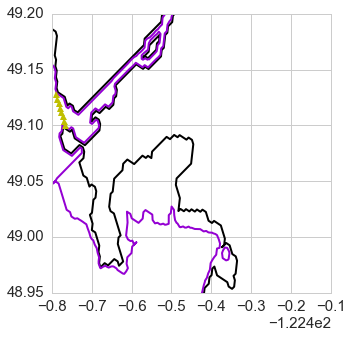

In [4]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
ax.plot(X[37:45,72],Y[37:45,72],'y^') ## transect4
ax.set_xlim([-123.2,-122.5])
ax.set_ylim([48.95,49.2])

In [5]:
## load salinity into a dict
paths = ['Oct2014nowind','Oct2014nowindBathy2_accurate']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternT = 'oct2014*_T.nc'
file_patternU = 'oct2014*_U.nc'
file_patternV = 'oct2014*_V.nc'
U = {}; V={}; S={};ssh = {}
for pa in paths:
    pathT = glob(os.path.join(base,pa, file_patternT))
    pathU = glob(os.path.join(base,pa, file_patternU))
    pathV = glob(os.path.join(base,pa, file_patternV))
    fU = nc.Dataset(pathU[0],'r');
    U[pa] = fU.variables['vozocrtx']
    fV = nc.Dataset(pathV[0],'r');
    V[pa] = fV.variables['vomecrty']
    depU = fU.variables['depthu']
    depV = fV.variables['depthv']
    fT = nc.Dataset(pathT[0],'r');
    S[pa] = fT.variables['vosaline']
    lon = fT.variables['nav_lon'] 
    lat = fT.variables['nav_lat']
    ssh[pa] = fT.variables['sossheig']
    time_counter = fT.variables['time_counter']
    depT = fT.variables['deptht']

In [6]:
def transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,t_st,t_en,S0,fresh_flag = 'fresh',\
                                y0lim =6e5, y1lim = 6000):
    """Same as transport_calculate function, but focus on a continous time period rather 
    than a specific time, including fresh water flux 'fresh' flag,
    salt flux 'salt' flag, and total flux 'None' flag"""
    UU = {}; VV= {};SS={};mask_ = {}
    jinds = np.arange(transects[tran]['jst']-1,transects[tran]['jen'])
    iinds = np.arange(transects[tran]['ist']-1,transects[tran]['ien'])
    for pa in paths:
        SS[pa] = np.zeros([time_counter.shape[0],depU.shape[0],jinds.shape[0],iinds.shape[0]])
        UU[pa] = np.zeros([time_counter.shape[0],depU.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        VV[pa] = np.zeros([time_counter.shape[0],depV.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        for t in np.arange(t_st,t_en+1):
            SS[pa][t] = S[pa][t,:,jinds,iinds]    
            mask_[pa]=np_mask[pa][:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
            SS[pa][t] = np.ma.masked_array(SS[pa][t],mask=mask_[pa]) ## mask sal=0 by tmask 
            UU[pa][t],VV[pa][t] = viz_tools.unstagger(U[pa][t,:,jinds,iinds],\
                                          V[pa][t,:,jinds,iinds])

    trans,trans_sur,trans_to= transport_time(SS,UU,VV,ssh,lon,lat,depU,depV,tran,t_st,t_en,\
                                                S0,fresh_flag = fresh_flag) ## get surface/total transport
        ## location
    return trans,trans_sur,trans_to

In [7]:
def transport_time(S,U,V,ssh,lon,lat,depU,depV,tran,t_st,t_en,S0,fresh_flag = 'fresh'):
    """This function was made to calculate total 
    transport/fresh water transport during a continuous 
    period, rather than the specific time 
    fresh_flag = 'fresh', fresh flux; 'salt',salt flux; 'None', total flux"""
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3' or tran =='4' or tran =='5' or tran =='7' or tran=='8' or tran =='9': ## cross-shelf transport
        for pa in paths:
            trans[pa] = np.zeros([time_counter.shape[0],depU.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']).shape[0]])
            for t in np.arange(t_st,t_en+1):
                for z in np.arange(depU.shape[0]):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']):
                        d = e2t[pa][j+transects[tran]['jst'],transects[tran]['ist']]

                        if fresh_flag == 'None':
                            ratio = 1
                        elif fresh_flag =='salt' or fresh_flag =='saltNoV':
                            ratio = S[pa][t][z,j+1,1]
                        elif fresh_flag =='fresh':
                            ratio = (S0 - S[pa][t][z,j+1,1])/S0
                        adj_ssh = 1+ssh[pa][t,j+transects[tran]['jst'],transects[tran]['ist']]\
                        /np.sum(e3t[pa][:,j+transects[tran]['jst'],\
                        transects[tran]['ist']]*tmask[pa][:,j+transects[tran]['jst'],transects[tran]['ist']])
                        if fresh_flag =='saltNoV':
                            trans[pa][t,z,j] = d*e3t[pa][z,j+transects[tran]['jst'],transects[tran]['ist']]*adj_ssh*ratio
                        else:
                            trans[pa][t,z,j] = U[pa][t,z,j,0]*d*e3t[pa][z,j+transects[tran]['jst'],transects[tran]['ist']]*adj_ssh*ratio
    else: ## along-shore transport
        for pa in paths:
            trans[pa]= np.zeros([time_counter.shape[0],depV.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']).shape[0]]);
            for t in np.arange(t_st,t_en+1):
                for z in np.arange(depV.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']):
                        d = e1t[pa][transects[tran]['jst'],i+transects[tran]['ist']]
                        if fresh_flag == 'None':
                            ratio = 1
                        elif fresh_flag =='salt' or fresh_flag =='saltNoV':
                            ratio = S[pa][t][z,1,i+1]
                        elif fresh_flag =='fresh':
                            ratio = (S0 - S[pa][t][z,1,i+1])/S0

                        adj_ssh = 1+ssh[pa][t,transects[tran]['jst'],i+transects[tran]['ist']]\
                        /np.sum(e3t[pa][:,transects[tran]['jst'],i+transects[tran]['ist']]*tmask[pa][:,transects[tran]['jst'],i+transects[tran]['ist']])
                        if fresh_flag =='saltNoV':
                            trans[pa][t,z,i] = d*e3t[pa][z,transects[tran]['jst'],i+transects[tran]['ist']]*adj_ssh*ratio ## shape of [40,54]
                        else:
                            trans[pa][t,z,i] = V[pa][t,z,0,i]*d*e3t[pa][z,transects[tran]['jst'],i+transects[tran]['ist']]*adj_ssh*ratio ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = np.nansum(trans[pa][t_st:t_en+1,0,:],axis = 1)
        trans_total[pa] = np.nansum(np.nansum(trans[pa][t_st:t_en+1],axis = 1),axis = 1)
 
    return trans, trans_surf,trans_total

# Volume flux calculation at river mouth transect

In [8]:
paths = ['Oct2014nowind','Oct2014nowindBathy2_accurate']
trans,trans_surf,trans_to=transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'4',0,719,30,fresh_flag='None')

In [9]:
nowind =np.nansum(np.nansum(trans['Oct2014nowind'][:,:,:],axis = 1),axis = 1)
nowind_2 = np.nansum(np.nansum(trans['Oct2014nowindBathy2_accurate'][:,:,:],axis = 1),axis = 1)

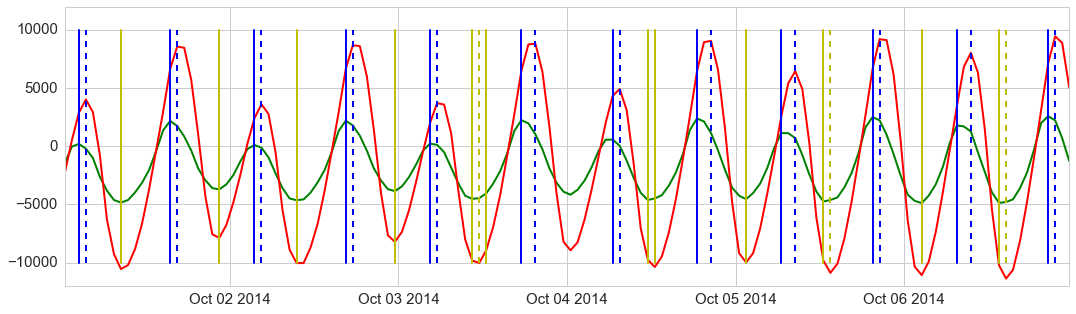

In [25]:
## first 6 days
fig, ax = plt.subplots(1,1,figsize = (18,5))
t = [datetime.datetime(2014,10,d,h,30) for d in np.arange(1,7,1) for h in np.arange(0,24)]
ax.plot(t,np.nansum(np.nansum(trans['Oct2014nowindBathy2_accurate'][0:6*24,0:5,:],axis = 1),axis = 1),'g')
ax.plot(t,np.nansum(np.nansum(trans['Oct2014nowind'][0:6*24,:,:],axis = 1),axis = 1),'r')
for start in np.arange(0,144,12):
    end = start+12
    a = np.nanargmax(nowind[start:end])+start
    b = np.nanargmin(nowind[start:end])+start
    c = np.nanargmax(nowind_2[start:end])+start
    d = np.nanargmin(nowind_2[start:end])+start
    ax.plot([t[a],t[a]],[-1e4,1e4],'b--')
    ax.plot([t[b],t[b]],[-1e4,1e4],'y--')
    ax.plot([t[c],t[c]],[-1e4,1e4],'b-')
    ax.plot([t[d],t[d]],[-1e4,1e4],'y-')
ax.set_ylim([-12e3,12e3])
plt.show()

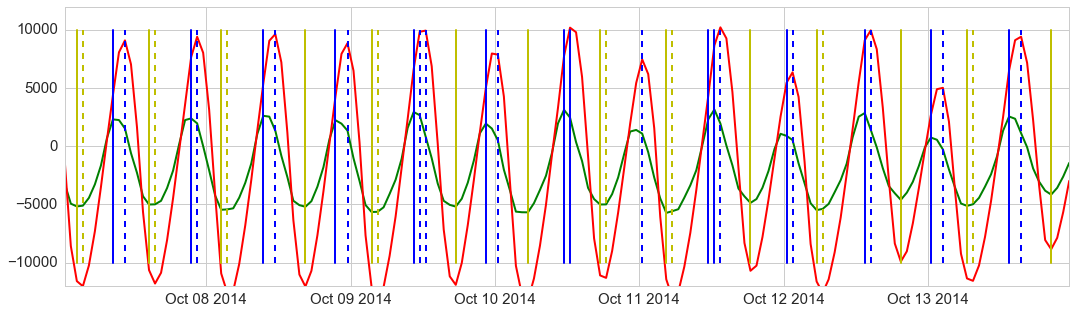

In [50]:
##  Oct 7-14
fig, ax = plt.subplots(1,1,figsize = (18,5))
t = [datetime.datetime(2014,10,d,h,30) for d in np.arange(7,14,1) for h in np.arange(0,24)]
ax.plot(t,np.nansum(np.nansum(trans['Oct2014nowindBathy2_accurate'][6*24:13*24,0:5,:],axis = 1),axis = 1),'g')
ax.plot(t,np.nansum(np.nansum(trans['Oct2014nowind'][6*24:13*24,:,:],axis = 1),axis = 1),'r')

for start in np.arange(144,312,12):
    end = start+12
    a = np.nanargmax(nowind[start:end])+start-144
    b = np.nanargmin(nowind[start:end])+start-144
    c = np.nanargmax(nowind_2[start:end])+start-144
    d = np.nanargmin(nowind_2[start:end])+start-144
    ax.plot([t[a],t[a]],[-1e4,1e4],'b--')
    ax.plot([t[b],t[b]],[-1e4,1e4],'y--')
    ax.plot([t[c],t[c]],[-1e4,1e4],'b-')
    ax.plot([t[d],t[d]],[-1e4,1e4],'y-')
ax.set_ylim([-12e3,12e3])
plt.show()

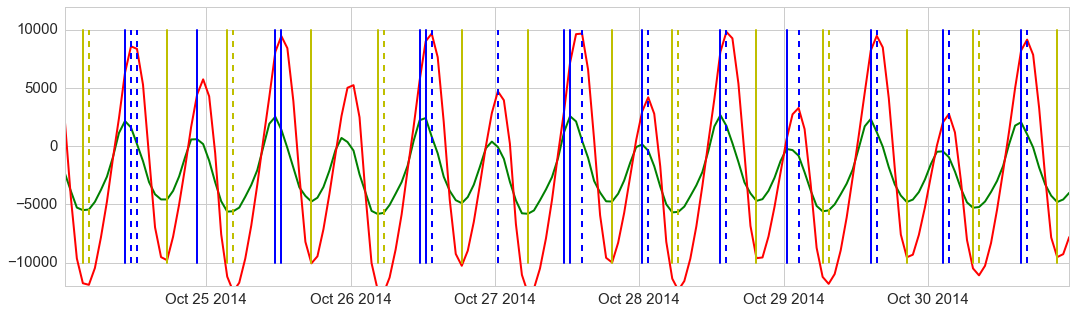

In [44]:
## last 6 days
fig, ax = plt.subplots(1,1,figsize = (18,5))
t = [datetime.datetime(2014,10,d,h,30) for d in np.arange(24,31,1) for h in np.arange(0,24)]
ax.plot(t,np.nansum(np.nansum(trans['Oct2014nowindBathy2_accurate'][23*24:720,0:5,:],axis = 1),axis = 1),'g')
ax.plot(t,np.nansum(np.nansum(trans['Oct2014nowind'][24*23:720,:,:],axis = 1),axis = 1),'r')
for start in np.arange(24*23,720,12):
    end = start+12
    a = np.nanargmax(nowind[start:end])+start-24*23
    b = np.nanargmin(nowind[start:end])+start-24*23
    c = np.nanargmax(nowind_2[start:end])+start-24*23
    d = np.nanargmin(nowind_2[start:end])+start-24*23
    ax.plot([t[a],t[a]],[-1e4,1e4],'b--')
    ax.plot([t[b],t[b]],[-1e4,1e4],'y--')
    ax.plot([t[c],t[c]],[-1e4,1e4],'b-')
    ax.plot([t[d],t[d]],[-1e4,1e4],'y-')
ax.set_ylim([-12e3,12e3])
plt.show()

In [17]:
for start in np.arange(0,696,6):
    end = start+12
    a = np.nanargmax(nowind[start:end])+start
    b = np.nanargmin(nowind[start:end])+start
    c = np.nanargmax(nowind_2[start:end])+start
    d = np.nanargmin(nowind_2[start:end])+start
    if a-b <= 0:
        print('Peak ebb time - peak flood time for bathy6 is ',b-a,
          ' Peak ebb time - peak flood time for bathy2 is ',d-c, 
           ' bathy6 - bathy2 is ',b-a-d+c)
    else:
        print('Peak flood time - peak ebb time for bathy6 is ',a-b,
          ' Peak flood time - peak ebb time for bathy2 is ',c-d, 
           ' bathy6 - bathy2 is ',a-b-c+d)## first value for bathy6,second for 2, value is high time -low time

Peak ebb time - peak flood time for bathy6 is  5  Peak ebb time - peak flood time for bathy2 is  6  bathy6 - bathy2 is  -1
Peak flood time - peak ebb time for bathy6 is  8  Peak flood time - peak ebb time for bathy2 is  7  bathy6 - bathy2 is  1
Peak ebb time - peak flood time for bathy6 is  6  Peak ebb time - peak flood time for bathy2 is  7  bathy6 - bathy2 is  -1
Peak ebb time - peak flood time for bathy6 is  4  Peak ebb time - peak flood time for bathy2 is  -5  bathy6 - bathy2 is  9
Peak ebb time - peak flood time for bathy6 is  5  Peak ebb time - peak flood time for bathy2 is  6  bathy6 - bathy2 is  -1
Peak flood time - peak ebb time for bathy6 is  8  Peak flood time - peak ebb time for bathy2 is  7  bathy6 - bathy2 is  1
Peak ebb time - peak flood time for bathy6 is  6  Peak ebb time - peak flood time for bathy2 is  7  bathy6 - bathy2 is  -1
Peak ebb time - peak flood time for bathy6 is  5  Peak ebb time - peak flood time for bathy2 is  5  bathy6 - bathy2 is  0
Peak ebb time - pea